# Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split as split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score, classification_report

In [2]:
data_proc = pd.read_csv('MHR_cleaned.csv')
data_proc

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,Risk
0,25,130,80,15.0,98.0,86,1
1,35,140,90,13.0,98.0,70,1
2,29,90,70,8.0,100.0,80,1
3,30,140,85,7.0,98.0,70,1
4,35,120,60,6.1,98.0,76,0
...,...,...,...,...,...,...,...
890,22,120,60,15.0,98.0,80,1
891,55,120,90,18.0,98.0,60,1
892,35,85,60,19.0,98.0,86,1
893,43,120,90,18.0,98.0,70,1


In [7]:
'''data_proc = data_proc[~((data_proc["BodyTemp"] > 100) & (data_proc["Risk"] == 0))]
data_proc = data_proc[~((data_proc["BS"] > 10) & (data_proc["Risk"] == 0) | (data_proc["BS"] > 10) & (data_proc["Risk"] == 1))]
data_proc = data_proc[~((data_proc["Age"] > 50) & (data_proc["Risk"] == 0) | (data_proc["Age"] > 50) & (data_proc["Risk"] == 1))]
data_proc = data_proc[~(data_proc["HeartRate"] < 55)]
'''

'data_proc = data_proc[~((data_proc["BodyTemp"] > 100) & (data_proc["Risk"] == 0))]\ndata_proc = data_proc[~((data_proc["BS"] > 10) & (data_proc["Risk"] == 0) | (data_proc["BS"] > 10) & (data_proc["Risk"] == 1))]\ndata_proc = data_proc[~((data_proc["Age"] > 50) & (data_proc["Risk"] == 0) | (data_proc["Age"] > 50) & (data_proc["Risk"] == 1))]\ndata_proc = data_proc[~(data_proc["HeartRate"] < 55)]\n'

In [8]:
from scipy import stats

z_scores = np.abs(stats.zscore(data_proc))

threshold = 3

# Find rows where all z-scores are within the threshold of -3 to 3
keep_rows = (z_scores < threshold).all(axis=1) & (z_scores > -threshold).all(axis=1)

# Filter the data_proc array to keep only the rows that meet the threshold criteria
data_proc = data_proc[keep_rows]
data_proc

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,Risk
0,25,130,80,15.0,98.0,86,1
1,35,140,90,13.0,98.0,70,1
2,29,90,70,8.0,100.0,80,1
3,30,140,85,7.0,98.0,70,1
4,35,120,60,6.1,98.0,76,0
...,...,...,...,...,...,...,...
889,48,120,80,11.0,98.0,88,1
890,22,120,60,15.0,98.0,80,1
891,55,120,90,18.0,98.0,60,1
893,43,120,90,18.0,98.0,70,1


# Modelling & Evaluation

In [9]:
# Processed Dataset
X_proc = data_proc.drop("Risk", axis=1)
y_proc = data_proc.Risk
x_train_proc, x_test_proc, y_train_proc, y_test_proc = split(X_proc, y_proc, train_size=0.8, test_size=0.2, random_state=1)


print(f"Processes data has {x_train_proc.shape[0]} train data and {x_test_proc.shape[0]} test data")

Processes data has 689 train data and 173 test data


## Base XGBoost

In [10]:
import xgboost as xgb

## Modified XGBoost

In [11]:
# Using processed dataset
xgb_classifier4 = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=5,
    gamma=0.1,
    n_estimators=1000,
    subsample=0.7,
    colsample_bytree=0.9,
    reg_alpha=0.1,
    reg_lambda=0.5,
    random_state=42)

xgb_classifier4.fit(x_train_proc, y_train_proc,)

eval_set = [(x_train_proc, y_train_proc), (x_test_proc, y_test_proc)]
xgb_classifier4.fit(x_train_proc, y_train_proc, eval_metric=["auc"], eval_set=eval_set, verbose=0)
y_pred_proc = xgb_classifier4.predict(x_test_proc)
y_prob = xgb_classifier4.predict_proba(x_test_proc)[:, 1]

print(f"Processed Dataset Accuracy: {accuracy_score(y_test_proc, y_pred_proc)}")
print(classification_report(y_test_proc, y_pred_proc))

C:\Users\admin\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Processed Dataset Accuracy: 0.930635838150289
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        66
           1       0.93      0.96      0.94       107

    accuracy                           0.93       173
   macro avg       0.93      0.92      0.93       173
weighted avg       0.93      0.93      0.93       173



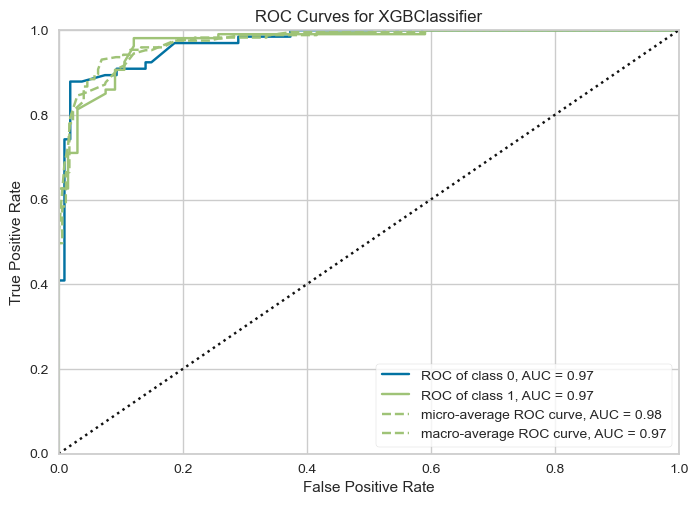

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [12]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(xgb_classifier4, classes=["0", "1"], support=True)

visualizer.fit(x_train_proc, y_train_proc)        # Fit the training data to the visualizer
visualizer.score(x_test_proc, y_test_proc)        # Evaluate the model on the test data
visualizer.show()

In [ ]:
# Define a function to take user input and make predictions
def predict_with_user_input(model):
    print("Enter values for features:")
    age = float(input("Age: "))
    systolic_bp = float(input("Systolic Blood Pressure: "))
    diastolic_bp = float(input("Diastolic Blood Pressure: "))
    blood_sugar = float(input("Blood Sugar: "))
    body_temp = float(input("Body Temperature: "))
    heart_rate = float(input("Heart Rate: "))

    new_data = pd.DataFrame({
        'Age': [age],
        'SystolicBP': [systolic_bp],
        'DiastolicBP': [diastolic_bp],
        'BS': [blood_sugar],
        'BodyTemp': [body_temp],
        'HeartRate': [heart_rate]
    })

    # Use the trained model to predict the outcome
    prediction = model.predict(new_data)

    if prediction[0] == 1:
        print("You are at risk.")
    else:
        print("You are not at risk.")


# Call the function with your trained model
predict_with_user_input(xgb_classifier4)

Enter values for features:
